<a href="https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/main/examples/jrVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *j*(*r*)-VAE: Learning (jointly) discrete and continuous representations of the arbitrary rotated image data


---

Here we introduce a joint (rotationally-invariant) VAE that can perform unsupervised classification and disentangle relevant continuous factors of variation at the same time.


---





Prepared by Maxim Ziatdinov

E-mail: ziatdinovmax@gmail.com

In [ ]:
#@title Installation
!pip install -q pyroved kornia

In [2]:
#@title Imports
from typing import Tuple

import pyroved as pv
import torch
import kornia as K
from torchvision import datasets
import matplotlib.pyplot as plt

In [3]:
#@title Helper functions
def rotate_images(imgdata, rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    torch.manual_seed(0)
    theta = torch.randint(*rotation_range, size=(len(imgdata),))
    imgdata = K.rotate(imgdata.float()[:, None], theta.float())
    imgdata = imgdata / imgdata.max()
    return imgdata, theta


def get_mnist_data(rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    !wget -qq www.di.ens.fr/~lelarge/MNIST.tar.gz
    !tar -zxf MNIST.tar.gz
    mnist_trainset = datasets.MNIST(
        root='.', train=True, download=False, transform=None)
    images_r, theta = rotate_images(mnist_trainset.data, rotation_range)
    return images_r, mnist_trainset.targets, theta

Get training data and create a dataloader object:

In [4]:
train_data, train_labels, angles = get_mnist_data(rotation_range=[-60, 61])
train_loader = pv.utils.init_dataloader(train_data, batch_size=64)

/usr/local/lib/python3.7/dist-packages/kornia/geometry/transform/imgwarp.py:186: UserWarning: The align_corners default value has been changed. By default now is set True in order to match cv2.warpAffine. In case you want to keep your previous behaviour set it to False. This warning will disappear in kornia > v0.6.
  warnings.warn(message)


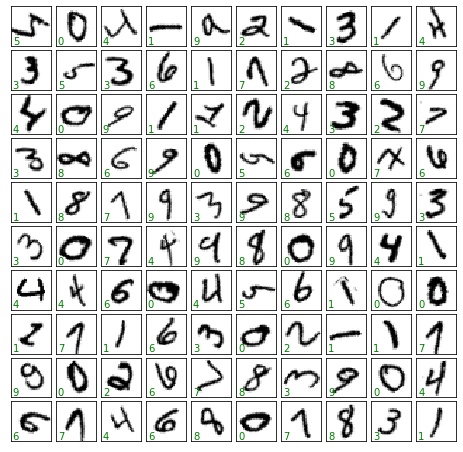

In [5]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im.squeeze(), cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

During training, we want our VAE model both assign the discrete class to the variables and find the optimal continuous latent code, i.e. perform classification and disentangle relevant variables at the same time. However, the problem with discrete (categorical) latent variables is that they cannot be backpropagated through samples. One common solution is to substitute a non-differentiable sample from a categorical distribution with a differentiable sample from a Gumbel-Softmax distribution. Another solution, which we are going to adapt here, is to marginalize out discrete latent variables via a full enumeration. This approach is generally associated with high computational costs but the recently available probabilistic programming libraries such as Pyro make this task easier by enabling parallel enumeration.

Initialize and train joint VAE model with rotational invariance:

In [6]:
in_dim = (28, 28)

# Initialize joint VAE model (note that we have to enter our "guess" about the number of discrete classes in the system)
jvae = pv.models.jiVAE(in_dim, latent_dim=2, discrete_dim=10, invariances=['r'], seed=0)

# # Initialize trainer (note that we are going to use parallel enumeration instead of Gumbel-Softmax approx)
trainer = pv.trainers.SVItrainer(jvae, lr=1e-3, enumerate_parallel=True)

# Train
kl_scale = torch.linspace(40, 4, 50)  # use a "time"-dependent KL scale factor (see e.g. https://arxiv.org/abs/1804.03599)
for e in range(100):
    sc = kl_scale[e] if e < len(kl_scale) else kl_scale[-1]
    trainer.step(train_loader, scale_factor=sc)
    trainer.print_statistics()

Epoch: 1 Training loss: 233.2949
Epoch: 2 Training loss: 220.7518
Epoch: 3 Training loss: 220.6112
Epoch: 4 Training loss: 220.5043
Epoch: 5 Training loss: 220.4487
Epoch: 6 Training loss: 220.4836
Epoch: 7 Training loss: 220.4251
Epoch: 8 Training loss: 220.4378
Epoch: 9 Training loss: 220.3620
Epoch: 10 Training loss: 220.3709
Epoch: 11 Training loss: 220.3269
Epoch: 12 Training loss: 220.3347
Epoch: 13 Training loss: 220.2863
Epoch: 14 Training loss: 220.2799
Epoch: 15 Training loss: 220.2226
Epoch: 16 Training loss: 220.2249
Epoch: 17 Training loss: 220.2475
Epoch: 18 Training loss: 220.1876
Epoch: 19 Training loss: 220.2065
Epoch: 20 Training loss: 220.1414
Epoch: 21 Training loss: 220.1655
Epoch: 22 Training loss: 220.1828
Epoch: 23 Training loss: 220.1696
Epoch: 24 Training loss: 220.1748
Epoch: 25 Training loss: 220.1272
Epoch: 26 Training loss: 220.0919
Epoch: 27 Training loss: 220.1365
Epoch: 28 Training loss: 220.0943
Epoch: 29 Training loss: 220.0404
Epoch: 30 Training loss

Visualize the learned latent manifold:

(note that classes are learned in an unsupervised manner and their order dpeneds on the (pseudo-)random initialization of model parameters)

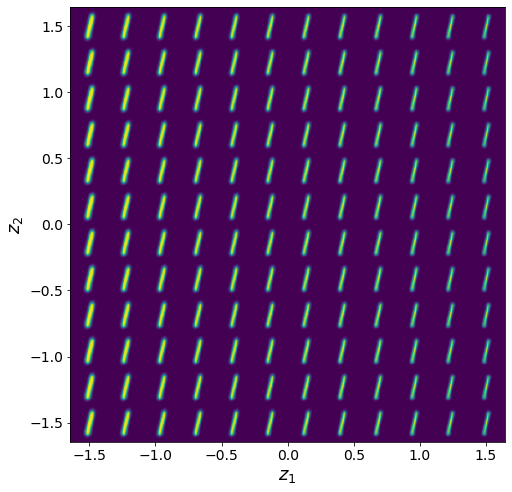

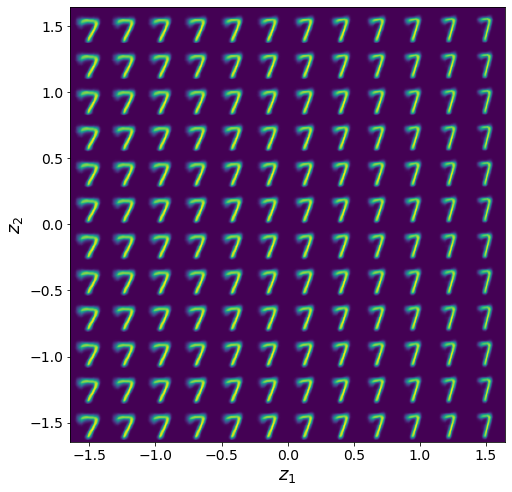

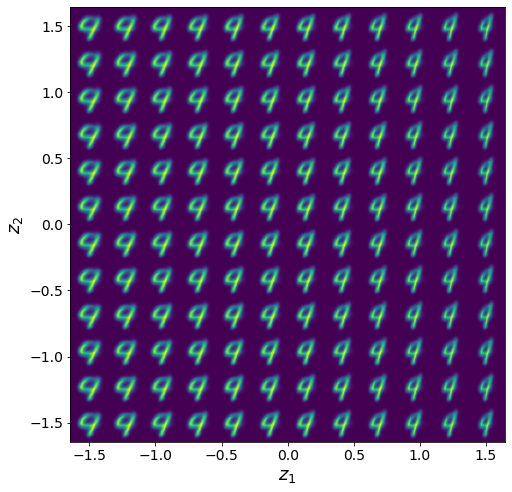

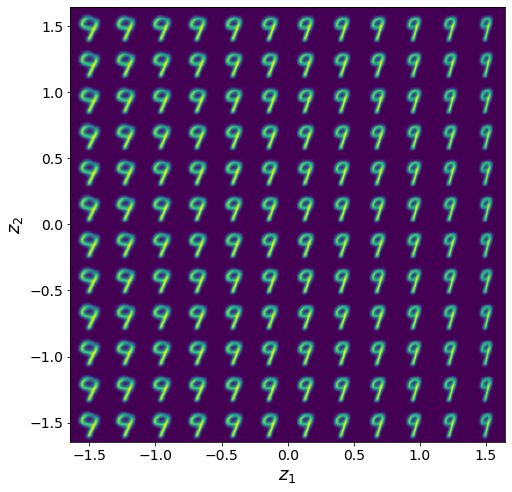

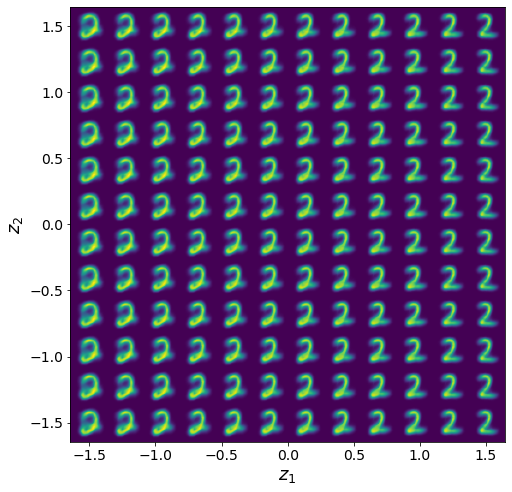

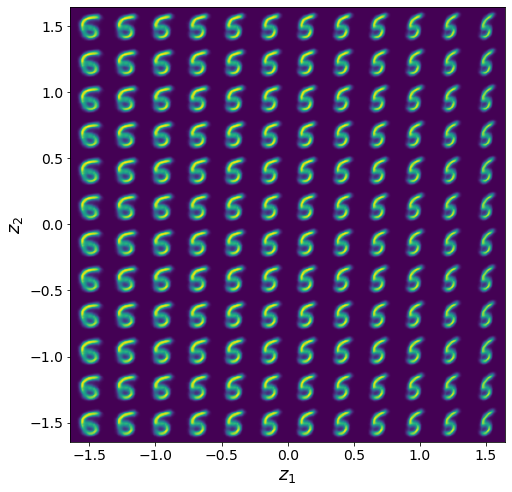

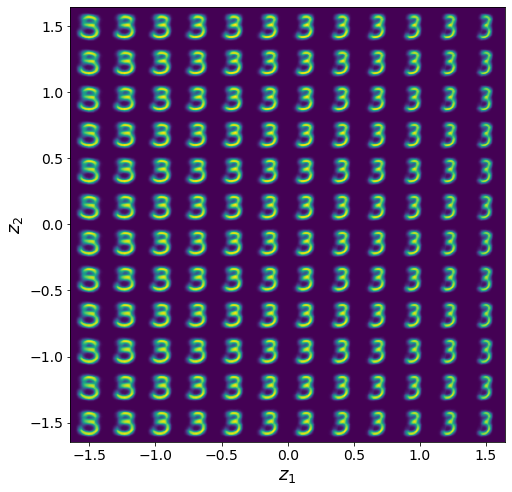

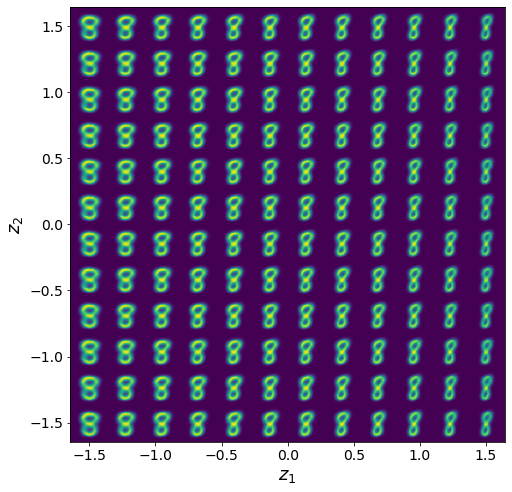

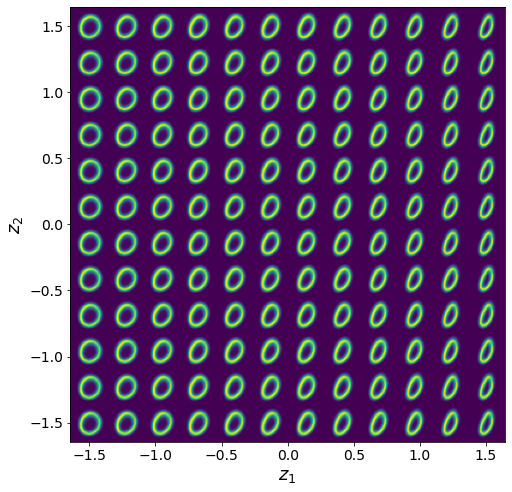

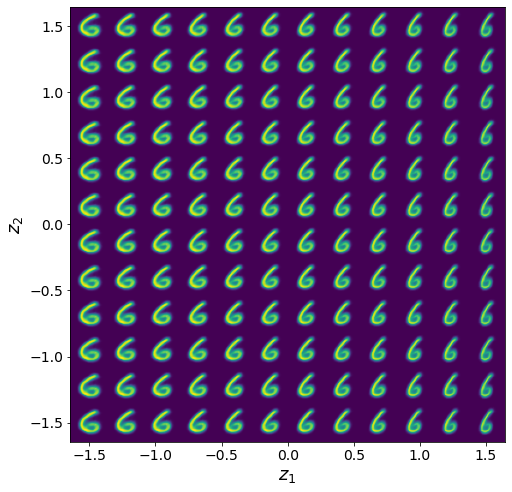

In [7]:
for i in range(10):
    jvae.manifold2d(d=12, disc_idx=i, cmap='viridis');

We can see that overall, our model did quite a remarkable job separating different classes without any supervision, as well as finding relevant factors of variation within each class.